In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from loader import CTDetectionDataset, get_albumentation, collate_fn
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.nn import functional as F
# from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
from pycocotools.coco import COCO
import sys

/opt/anaconda3/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = "../data/output"


Transforms

In [3]:
coc = COCO(os.path.join(DATASET_PATH, "train/images", "_annotations.coco.json"))
categories = coc.cats
n_classes = len(categories.keys())
n_classes, categories

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(2,
 {0: {'supercategory': None, 'id': 0, 'name': 'background'},
  1: {'supercategory': 'bone', 'id': 1, 'name': 'bone marrow'}})

In [4]:
classes = []
for i in categories.items():
    classes.append(i[1]["name"])

In [5]:
train_dataset = CTDetectionDataset(root=DATASET_PATH, transforms=get_albumentation(True))
val_dataset = CTDetectionDataset(root=DATASET_PATH, split="valid", transforms=get_albumentation(False))
test_dataset = CTDetectionDataset(root=DATASET_PATH, split="test", transforms=get_albumentation(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627]
loading annotations into memory

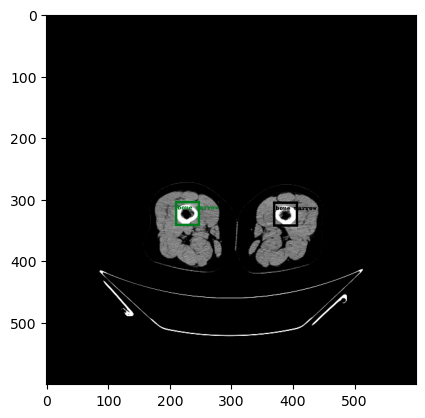

In [8]:
sample = train_dataset[12]
img_int = torch.tensor(sample[0]*255, dtype=torch.uint8)

# plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(draw_bounding_boxes(img_int, 
                               sample[1]['boxes'], 
                               [classes[i] for i in sample[1]['labels']],
                               width=4).permute(1,2,0)
)
plt.show()

In [7]:
len(train_dataset), len(val_dataset), len(test_dataset)


(177, 160, 118)

In [17]:
## USE FASTERRCNN MOBILENET
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes) 

In [18]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)

In [19]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [20]:
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
model.eval()
predictions = model(x)

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [22]:
model = model.to(device)

In [17]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, nesterov=True, weight_decay=1e-4)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)

In [18]:
from tqdm import tqdm

In [19]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.to(device)
    model.train()
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()
    
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}: lr: {:.6f} loss: {:.6f}, loss_classifier: {:.6f}, loss_box_reg: {:.6f}, loss_rpn_box_reg: {:6f}, loss_objectness: {:.6f}".format(
        epoch, optimizer.param_groups[0]["lr"], np.mean(all_losses), 
        all_losses_dict["loss_classifier"].mean(),
        all_losses_dict["loss_box_reg"].mean(),
        all_losses_dict["loss_rpn_box_reg"].mean(),
        all_losses_dict["loss_objectness"].mean(),
    ))
    


In [20]:
num_epochs = 2

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=28)
    lr_scheduler.step()


100%|██████████| 177/177 [03:04<00:00,  1.04s/it]


Epoch 0: lr: 0.010000 loss: 0.624147, loss_classifier: 0.203424, loss_box_reg: 0.407451, loss_rpn_box_reg: 0.001902, loss_objectness: 0.011370


100%|██████████| 177/177 [02:32<00:00,  1.16it/s]

Epoch 1: lr: 0.010000 loss: 0.338393, loss_classifier: 0.105451, loss_box_reg: 0.229509, loss_rpn_box_reg: 0.000631, loss_objectness: 0.002802


In [30]:
model.eval()
torch.cuda.empty_cache()
img, _ = test_dataset[0]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]